## Import Statements

In [1]:
import shapefile
import matplotlib.pyplot as plt
from math import sqrt
import random
import utm
import re
%matplotlib inline

## Global Variables

In [2]:
allRoadPoints = []
allRoadTypes = []
allRoadLengths = []
newRoadPoints = []
intersections = []
reqVillagesKeys = []
cntx = 0

## MST Graph Class

In [25]:
l = []
st = None
vis = []
val = 0

class Node:
    def __init__(self,x,y,name):
        self.x = x
        self.y = y
        self.name = name
    def displayNodeDetails(self):
        print("\nName : ",self.name,"\nX : ",self.x,"\nY : ",self.y)

class Edge:
    def __init__(self,name1,name2,cost):
        self.node1 = name1
        self.node2 = name2
        self.cost = cost
    def displayEdgeDetails(self):
        print("\nNode1 : ",self.node1,"\nNode2 : ",self.node2,"\nCost : ",self.cost)

class Graph:
    def __init__(self):
        self.visited = []
        self.selected = []
        self.nodes = []
        self.edges = []
    def addNode(self,x,y,name):
        temp = Node(x,y,name)
        self.nodes.append(temp)
    def addEdge(self,name1,name2,cost):
        temp = Edge(name1,name2,cost)
        self.edges.append(temp)
    def getcost(self,edge):
        return edge.cost
    def findNode(self,name):
        for i in range(len(g.nodes)):
            if(name == g.nodes[i].name): return i
    def getNextEdges(self,start):
        global st, vis, val
        if(start not in vis): 
            vis.append(start)
            l=[e for e in self.selected if e.node1 == start or e.node2 == start]
            for i in l:
                if(i.node1 not in vis or i.node2 not in vis):
                    if(i.node2 == st or i.node1 == st): val = 1
                    elif(i.node1 == start): self.getNextEdges(i.node2)
                    elif(i.node2 == start): self.getNextEdges(i.node1)
        if(val == 1): return False
        else: return True
    def sortEdges(self):
        self.edges = sorted(self.edges, key=self.getcost)
    def kruskal(self):
        global st, vis, val
        i = 0
        while(i<len(self.edges)):
            vis = []
            val = 0
            edge = self.edges[i]
            st = edge.node2
            if(self.getNextEdges(edge.node1) and len(reqVillagesNames-set(self.visited))):
                self.selected.append(edge)
                print(len(reqVillagesNames-set(self.visited)))
                if(edge.node1 not in self.visited): self.visited.append(edge.node1)
                if(edge.node2 not in self.visited): self.visited.append(edge.node2)
            i+=1

## Functions for shapefile details extraction

In [4]:
# fn to get points from a shape variable
def getVillagepoints(shpVar):
    return [shpVar.shape(i).points[0] for i in range(len(shpVar.shapes()))]

# fn to display any point given index
def displaypoints(points, tp = 1): 
    x = [pt[0] for pt in points]
    y = [pt[1] for pt in points]
    hnd = 0
    if(tp == 1):
        hnd, = plt.plot(x,y,'ro',label="Villages")
    else:
        hnd, = plt.plot(x,y,'ko',label="Intersections")
    return hnd
    
# fn to get fields and records of a shape variable
def getFieldsAndRecords(shpVar):
    return shpVar.fields, shpVar.records()

# fn to display all points of a road
def addRoadPoints(recIndex,rdShapes):
    global allRoadPoints
    print('%d Points of %d road' %(len(rdShapes.shape(recIndex).points),recIndex+1),rdShapes.shape(recIndex).points)
    allRoadPoints.append(rdShapes.shape(recIndex).points)
    
# plotting pts to see if they make a road
def plotRoadPoints(points, types, villCoords = None, intersections = None):
    i = 0
    plt.figure(figsize=(40,40))
    for l in points:
        x = [t[0] for t in l]
        y = [t[1] for t in l]
        tp = types[i]
        if(tp == 1): hnd1, = plt.plot(x,y,color='blue',label="Major Roads")
        elif(tp == 2): hnd2, = plt.plot(x,y,color='yellowgreen',label="Minor Roads")
        elif(tp == 3): hnd3, = plt.plot(x,y,color='coral',label="Muddy Roads")
        i += 1
    if(intersections != None): 
        hnd5 = displaypoints(intersections,0)
        hnd4 = displaypoints(villCoords,1)
        plt.legend(handles=[hnd1, hnd2, hnd3, hnd4, hnd5],fontsize=20)
    else:
        hnd4 = displaypoints(villCoords,1)
        plt.legend(handles=[hnd1, hnd2, hnd3, hnd4],fontsize=20)
    plt.show()
    
# fn to display road details given index 
def showroadDetails(rdFields, rdRec, rdShapes):
    for index in range(len(rdRec)):
        for i in range(len(rdFields)-1):
            if('Name' in rdFields[i+1][0]): 
                if('MR' in rdRec[index][i]):
                    allRoadTypes.append(1)
                elif('Minor' in rdRec[index][i]):
                    allRoadTypes.append(2)
                else:
                    allRoadTypes.append(3)
            print(rdFields[i+1][0]," : ",rdRec[index][i])
            if('Shape_Leng' in rdFields[i+1][0]):
                allRoadLengths.append(rdRec[index][i])
        addRoadPoints(index,rdShapes)
        print("=================================================================================================")   

# fn to find the distances of every village from every single point in each road
def findDistances(villCoords):
    allVillagesDist = {}
    i = 1
    for vlg in villCoords:
        d = []
        vx = vlg[0]
        vy = vlg[1]
        for rd in allRoadPoints:
            dist = []
            for rdpt in rd:
                rx = rdpt[0]
                ry = rdpt[1]
                dist.append(sqrt((ry-vy)**2+(rx-vx)**2))
            d.append(dist)
        allVillagesDist[i] = d
        i+=1
    return allVillagesDist

# fn to find n closest roads to a village
def findClosestn(road, allVillagesDist, rdRec, n=5):
    villMins = {}
    _,rdRecCopy = getFieldsAndRecords(road)

    for key in allVillagesDist.keys():
        minDist = []
        d = allVillagesDist[key]
        for dist in d:
            minDist.append((min(dist),dist.index(min(dist))))
        temp = []
        for k in range(n):
            minVal = min(minDist)
            minValIndex = minDist.index(minVal)
            l = [minVal, rdRec.index(rdRecCopy[minValIndex]), rdRecCopy[minValIndex][4]]
            if 'MR' in rdRecCopy[minValIndex][0]:
                l.append(1)
            elif 'Minor' in rdRecCopy[minValIndex][0]:
                l.append(2)
            else:
                l.append(3)
            temp.append(l)
            rdRecCopy.remove(rdRecCopy[minValIndex])
            minDist.remove(minVal)
        villMins[key] = temp
        _,rdRecCopy = getFieldsAndRecords(road)
    return villMins

# fn to plot closest n roads with their villaes
def plotClosestn(rdShape, villMin, points):
    selectedRoads = []
    selectedTypes = []
    for k in villMins.keys():
        sl = []
        indices = [t[1] for t in villMins[k]]
        types = [t[3] for t in villMins[k]]
        for i in indices:
            sl.append(road.shape(i).points)
        selectedRoads.append(sl)
        selectedTypes.append(types)
    i = 1
    plt.figure(figsize=(20,20))
    for vRoads in selectedRoads:
        for rd in vRoads:
            x = [t[0] for t in rd]
            y = [t[1] for t in rd]
            rand = random.randint(100000,999999)
            hnd1, = plt.plot(x,y,color='#'+str(rand), label="roads")
            hnd2, = plt.plot(villCoords[i-1][0], villCoords[i-1][1], 'ko', label="Villages")
        plt.legend(handles=[hnd1, hnd2])
        i += 1
    plt.show()

# fn to find intersection point
def findIntersection(p1, p2, p3, p4):
    a1 = p2[1] - p1[1]
    b1 = p1[0] - p2[0]
    c1 = a1*p1[0] + b1*p1[1]
    a2 = p4[1] - p3[1]
    b2 = p3[0] - p4[0]
    c2 = a2*p3[0] + b2*p3[1]
    
    det = a1*b2 - a2*b1
    if(det == 0):
        return None
    else:
        x = (b2*c1 - b1* c2)/det
        y = (a1*c2 - a2*c1)/det
        if(x >= min(p1[0],p2[0]) and x <= max(p1[0],p2[0]) and y >= min(p1[1],p2[1]) and y <= max(p1[1],p2[1]) 
          and x >= min(p3[0],p4[0]) and x <= max(p3[0],p4[0]) and y >= min(p3[1],p4[1]) and y <= max(p3[1],p4[1])): 
            return (x,y)
        else:
            return None

#fn to check if a point is on the equation of line
def solvesEquation(chkpt, p1, p2):
    a1 = p2[1] - p1[1]
    b1 = p1[0] - p2[0]
    c1 = a1*p1[0] + b1*p1[1]
    if(c1 == (a1*chkpt[0]+b1*chkpt[1])):
        return True
    else: 
        return False

# fn to plot intersections
def plotIntersections(roadp, roadt, villCoords=None):
    global intersections, newRoadPoints
    for rd1 in roadp:
        prevCnt = len(intersections)
        for j in range(len(rd1)-1):
            p1 = rd1[j]
            p2 = rd1[j+1]
            for rd2 in roadp:
                for l in range(len(rd2)-1):
                    p3 = rd2[l]
                    p4 = rd2[l+1]
                    val = findIntersection(p1, p2, p3, p4)
                    if(val!=None): 
                        intersections.append(val)
                    if(rd1 != rd2):
                        if(p1 == p3 or p1 == p4 or solvesEquation(p1,p3,p4)): 
                            intersections.append(p1)
                        if(p2 == p3 or p2 == p4 or solvesEquation(p2,p3,p4)): 
                            intersections.append(p2)
        newRoadPoints.append(intersections[prevCnt:len(intersections)])
    print("\nIntersections found : ",len(set(intersections)))
    plotRoadPoints(roadp, roadt, villCoords=villCoords, intersections=set(intersections))
    
# fn to convert all the utm coordinates to lattitude longitude
def convertToLatLong(roadp=None, villp=None):
    if(roadp!=None):
        llPoints = []
        for rd in roadp:
            rdPoints = []
            for pt in rd:
                rdPoints.append(utm.to_latlon(pt[0],pt[1],44,'R'))
            llPoints.append(rdPoints)
        return llPoints
    else:
        llPoints = []
        for pt in villp:
            llPoints.append(utm.to_latlon(pt[0],pt[1],44,'R'))
        return llPoints

# fn to calculate and find villlages as a road pt
def villToRoad(vmins=None):
    
    Names = []
    predictableVill = []
    for key in villMins.keys():
        if(villMins[key][0][0][0]!=0):
            print(villMins[key][0])
        else:
            predictableVill.append(villMins[key][0])
    
    for i in predictableVill:
        Names.append("r"+str(i[1])+"p"+str(i[0][1]))
    return Names

## Code Execution

In [5]:
road = shapefile.Reader("Data/Road_Network.shp")
vill = shapefile.Reader("Data/Villages.shp")

In [6]:
villCoords = getVillagepoints(vill)

In [7]:
rdFields, rdRec = getFieldsAndRecords(road)

In [8]:
showroadDetails(rdFields, rdRec, road)

Name  :  MR1
PREFIX  :  Dharampur Chauk
PRE_Type  :  Chauk
SUFFIX  :  Race Course End
FULL_NAME  :  Race Course to Dharampur Road
Oneway  :  T
Shape_Leng  :  78.307448375
FT_SpeedLi  :  80
TF_SpeedLi  :  80
FT_Time  :  0.0587305862812
TF_Time  :  0.0587305862812
3 Points of 1 road [(216094.7971999999, 3356367.9661), (216083.13410000037, 3356324.9970999993), (216084.36180000007, 3356291.2357)]
Name  :  MR2
PREFIX  :  Dhrampur Chauk
PRE_Type  :  Chauk
SUFFIX  :  River End
FULL_NAME  :  Dharampur Road
Oneway  :  F
Shape_Leng  :  1622.69599276
FT_SpeedLi  :  80
TF_SpeedLi  :  80
FT_Time  :  1.21702199457
TF_Time  :  1.21702199457
43 Points of 2 road [(216084.36180000007, 3356291.2357), (216091.7279000003, 3356239.0591), (216092.9556, 3356217.5746), (216096.09190000035, 3356189.7958000004), (216097.2525000004, 3356179.5163000003), (216099.66949999984, 3356162.9042000007), (216099.20909999963, 3356147.2512), (216101.97140000015, 3356130.217), (216101.30420000013, 3356113.2015000004), (216101

Oneway  :  
Shape_Leng  :  35.4200583015
FT_SpeedLi  :  26
TF_SpeedLi  :  26
FT_Time  :  0.0817385960803
TF_Time  :  0.0817385960803
3 Points of 138 road [(216521.0488, 3355793.3477), (216508.04839999974, 3355776.5908000004), (216499.33710000012, 3355765.362299999)]
Name  :  Street
PREFIX  :  strart End
PRE_Type  :  
SUFFIX  :  
FULL_NAME  :  Street75
Oneway  :  FT
Shape_Leng  :  123.268991302
FT_SpeedLi  :  26
TF_SpeedLi  :  26
FT_Time  :  0.284466903004
TF_Time  :  0.284466903004
9 Points of 139 road [(216502.58299999963, 3355762.9068), (216493.61429999955, 3355753.5721000005), (216486.0683000004, 3355743.5692999996), (216473.8049999997, 3355727.3133000005), (216462.48840000015, 3355735.8585), (216451.23170000035, 3355744.3585), (216468.7374999998, 3355766.4712000005), (216473.8049999997, 3355765.0891999993), (216482.06819999963, 3355778.4263000004)]
Name  :  Street
PREFIX  :  
PRE_Type  :  
SUFFIX  :  
FULL_NAME  :  Street76
Oneway  :  FT
Shape_Leng  :  69.8505030563
FT_SpeedLi  :  

Shape_Leng  :  95.4383603403
FT_SpeedLi  :  27
TF_SpeedLi  :  27
FT_Time  :  0.212085245201
TF_Time  :  0.212085245201
5 Points of 249 road [(216832.69049999956, 3356080.0590000004), (216868.2823999999, 3356062.9170999993), (216854.00129999965, 3356031.5908000004), (216849.8552000001, 3356025.6019), (216855.84399999958, 3356012.7028)]
Name  :  Street
PREFIX  :  Dhram
PRE_Type  :  
SUFFIX  :  Street End
FULL_NAME  :  Street431
Oneway  :  
Shape_Leng  :  31.5457179113
FT_SpeedLi  :  35
TF_SpeedLi  :  35
FT_Time  :  0.0540783735622
TF_Time  :  0.0540783735622
3 Points of 250 road [(216826.36039999966, 3356046.7931999993), (216841.56909999996, 3356038.4285000004), (216854.00129999965, 3356031.5908000004)]
Name  :  Street
PREFIX  :  Dhram
PRE_Type  :  
SUFFIX  :  Street End
FULL_NAME  :  Street432
Oneway  :  
Shape_Leng  :  35.2928790812
FT_SpeedLi  :  35
TF_SpeedLi  :  35
FT_Time  :  0.0605020784249
TF_Time  :  0.0605020784249
4 Points of 251 road [(216841.56909999996, 3356038.4285000004),

TF_SpeedLi  :  32
FT_Time  :  0.0795358759821
TF_Time  :  0.0795358759821
5 Points of 346 road [(217328.0887000002, 3355434.3880000003), (217310.14039999992, 3355437.5080999993), (217312.59740000032, 3355445.4932000004), (217321.8186999997, 3355444.295499999), (217328.3125, 3355443.4520999994)]
Name  :  Street
PREFIX  :  
PRE_Type  :  
SUFFIX  :  
FULL_NAME  :  Street262
Oneway  :  TF
Shape_Leng  :  82.7630234371
FT_SpeedLi  :  32
TF_SpeedLi  :  32
FT_Time  :  0.155180668945
TF_Time  :  0.155180668945
14 Points of 347 road [(217310.14039999992, 3355437.5080999993), (217300.31259999983, 3355439.3508), (217297.85560000036, 3355430.7513999995), (217296.62710000016, 3355427.6801999994), (217292.94170000032, 3355427.0659999996), (217290.4846999999, 3355425.8375000004), (217289.2561999997, 3355418.466600001), (217288.02780000027, 3355415.3954000007), (217283.72809999995, 3355411.0956999995), (217279.42839999963, 3355403.1106000002), (217278.19990000036, 3355401.2678999994), (217276.971400000

Name  :  Street
PREFIX  :  
PRE_Type  :  
SUFFIX  :  
FULL_NAME  :  Street150
Oneway  :  
Shape_Leng  :  123.485986122
FT_SpeedLi  :  29
TF_SpeedLi  :  29
FT_Time  :  0.25548824715
TF_Time  :  0.25548824715
2 Points of 430 road [(216916.33040000033, 3355551.296599999), (216815.79970000032, 3355623.0068999995)]
Name  :  Street
PREFIX  :  
PRE_Type  :  
SUFFIX  :  
FULL_NAME  :  Street151
Oneway  :  FT
Shape_Leng  :  62.4802330696
FT_SpeedLi  :  29
TF_SpeedLi  :  29
FT_Time  :  0.12926944773
TF_Time  :  0.12926944773
2 Points of 431 road [(216916.33040000033, 3355551.296599999), (216951.22699999996, 3355603.123299999)]
Name  :  Street
PREFIX  :  
PRE_Type  :  
SUFFIX  :  
FULL_NAME  :  Street152
Oneway  :  FT
Shape_Leng  :  46.0929852139
FT_SpeedLi  :  29
TF_SpeedLi  :  29
FT_Time  :  0.0953647969943
TF_Time  :  0.0953647969943
4 Points of 432 road [(216979.21339999977, 3355639.7474000007), (216978.83189999964, 3355639.2481999993), (216972.8415000001, 3355631.4089), (216951.22699999996, 

PREFIX  :  start end
PRE_Type  :  
SUFFIX  :  
FULL_NAME  :  Street332
Oneway  :  
Shape_Leng  :  4.12040246196
FT_SpeedLi  :  24
TF_SpeedLi  :  24
FT_Time  :  0.0103010061549
TF_Time  :  0.0103010061549
2 Points of 541 road [(216129.17929999996, 3356156.2930999994), (216127.33660000004, 3356152.6076999996)]


In [9]:
allVillagesDist = findDistances(villCoords)
villMins = findClosestn(road, allVillagesDist, rdRec, 4)
#reqVillagesNames = villToRoad(villMins)

In [10]:
'''
Converting to lat-lon coordinates
'''
allRoadsLatLong = convertToLatLong(roadp=allRoadPoints)
allVillagesLatLong = convertToLatLong(villp=villCoords)


Intersections found :  1030


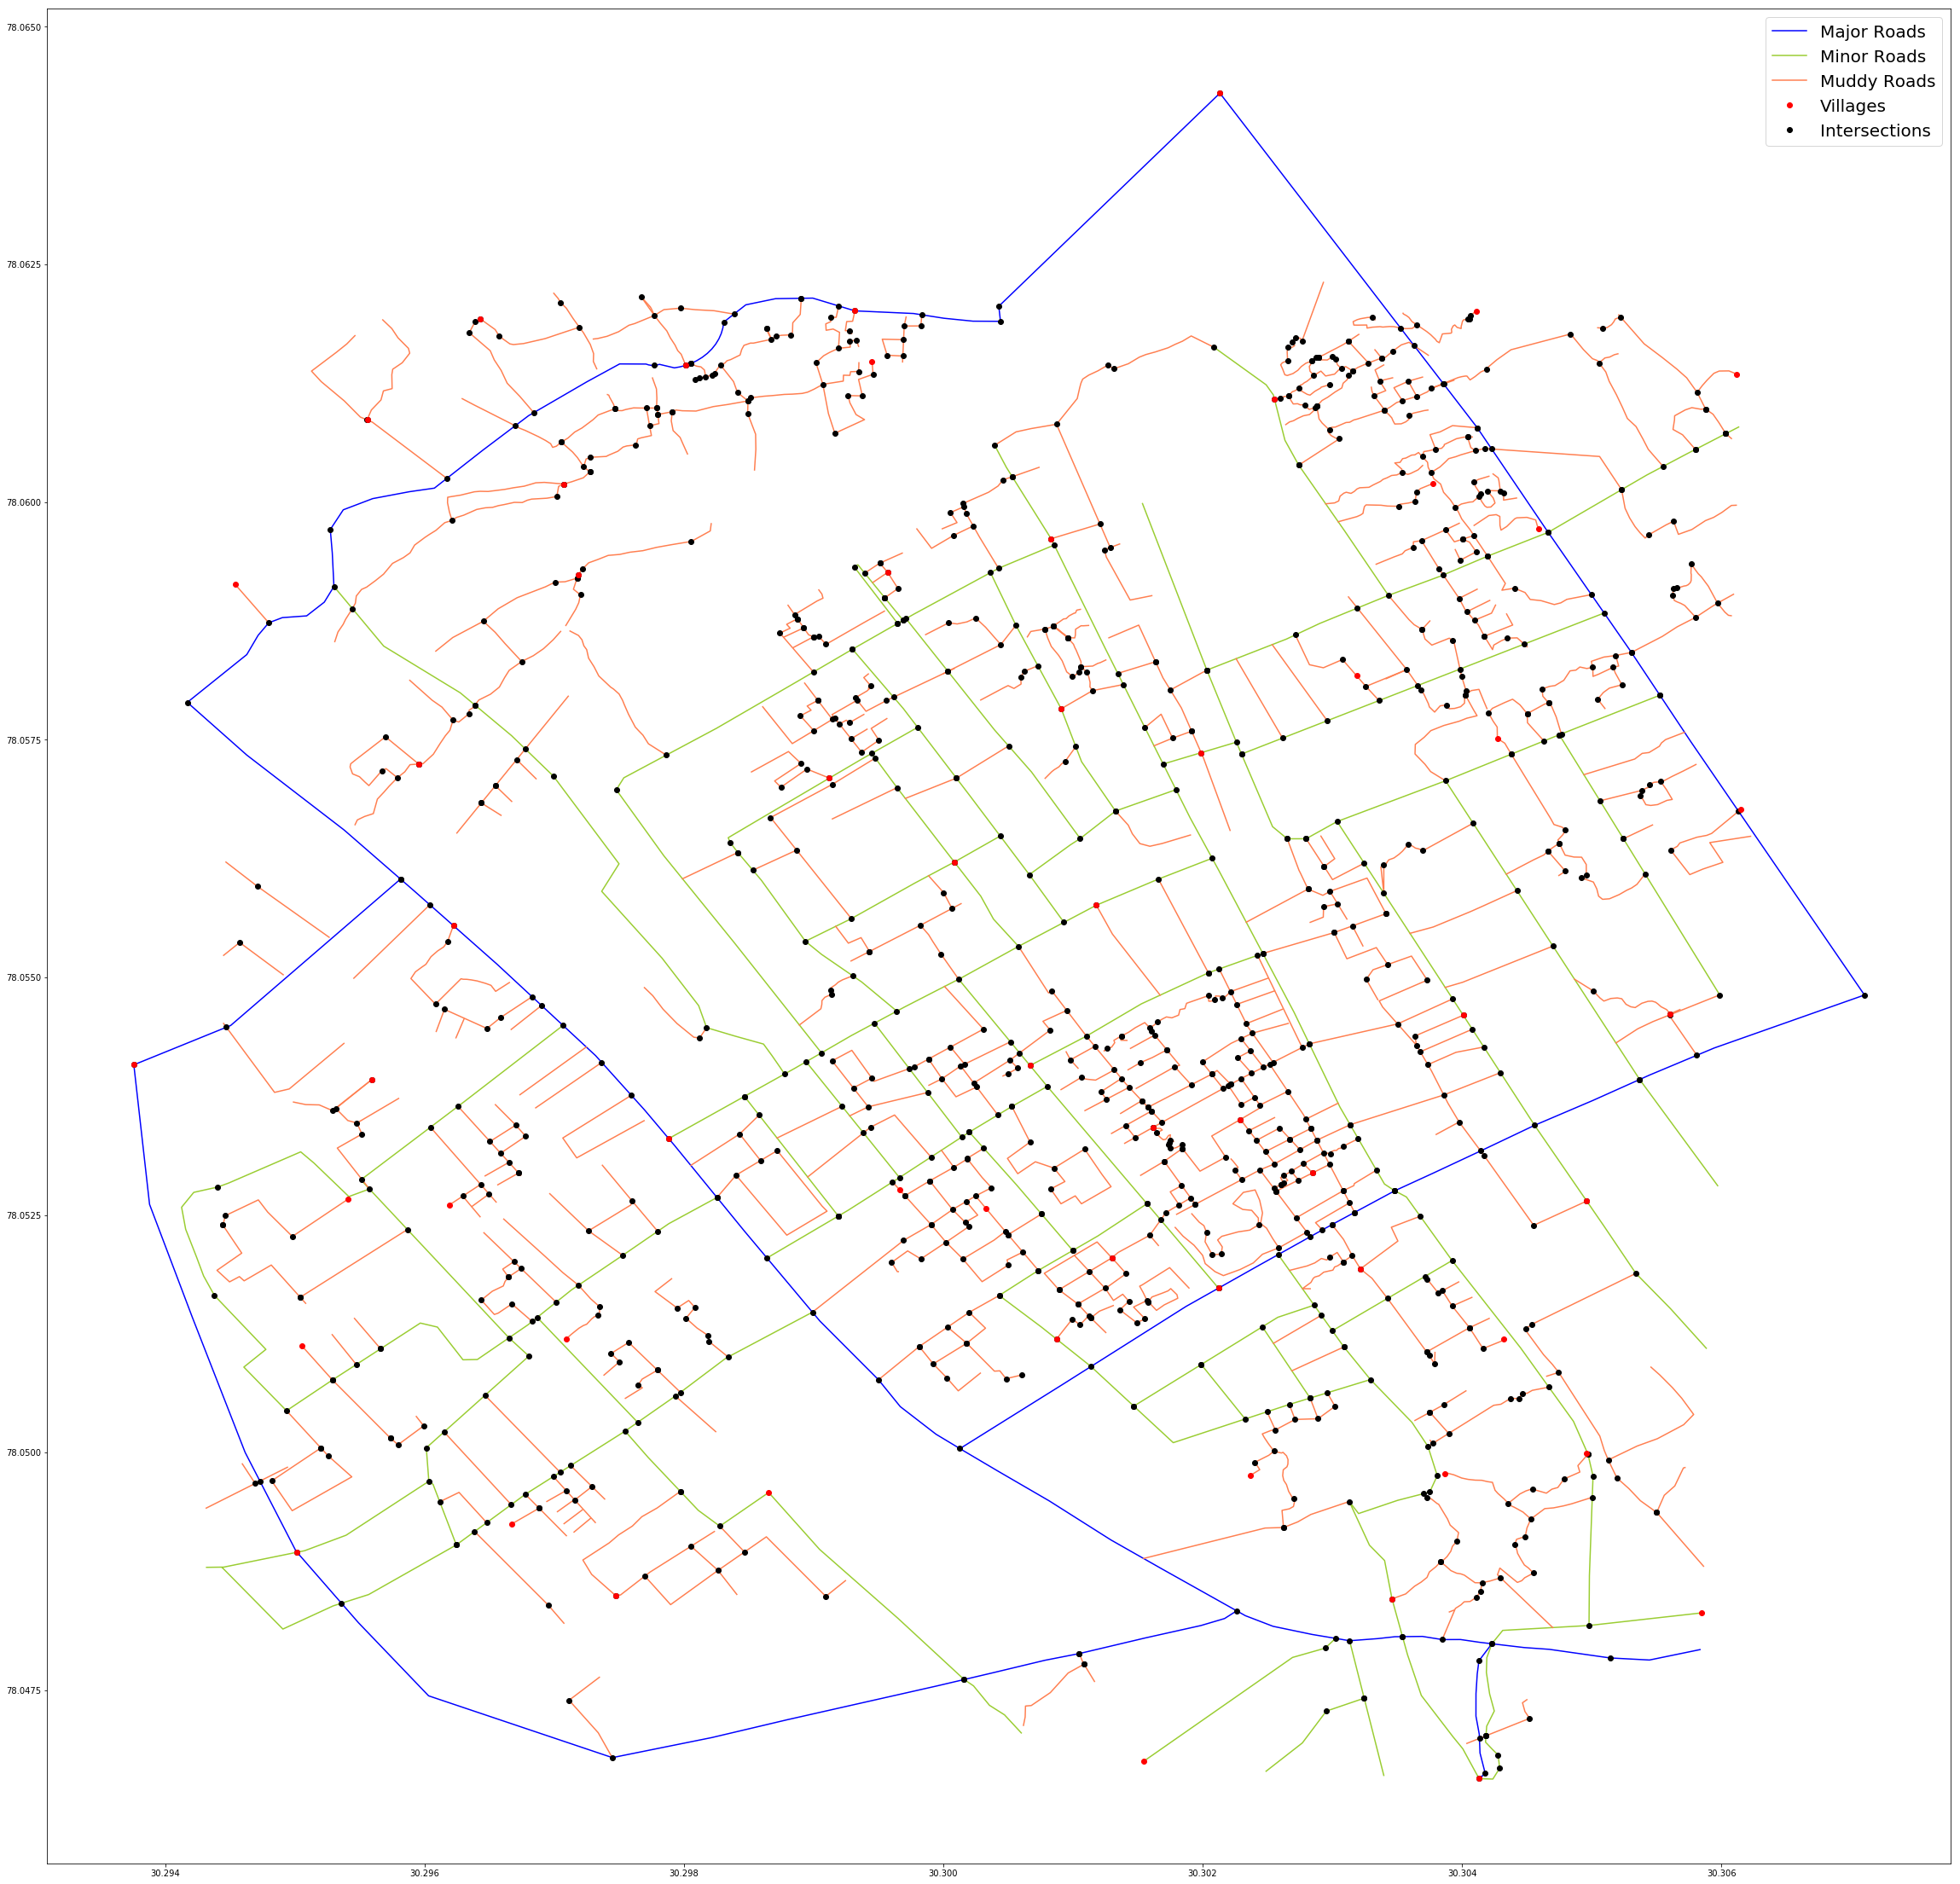

In [11]:
plotIntersections(allRoadsLatLong, allRoadTypes, allVillagesLatLong)

In [12]:
bef = []
for rd in allRoadsLatLong:
    bef.append(len(rd))

In [13]:
for i in range(len(allRoadsLatLong)):
    for j in range(len(newRoadPoints[i])):
        index = [n for n,pt in enumerate(allRoadsLatLong[i]) if pt[0]>newRoadPoints[i][j][0]]
        try:
            allRoadsLatLong[i].insert(index[0]-1,newRoadPoints[i][j])
        except:
            allRoadsLatLong[i].append(newRoadPoints[i][j])

In [14]:
aft = []
for rd in allRoadsLatLong:
    aft.append(len(rd))

In [15]:
sum(bef), sum(aft)

(3351, 7307)

In [16]:
villCoords = [(t[0],t[1]) for t in villCoords]

## MST construction

In [26]:
g = Graph()

In [27]:
addedPoints = []
reqVillagesNames = []
for i in range(len(allRoadPoints)):
    for j in range(len(allRoadPoints[i])-1):
        pt1 = allRoadPoints[i][j]
        pt2 = allRoadPoints[i][j+1]
        g.addNode(pt1[0],pt1[1],"r"+str(i+1)+"p"+str(j+1))
        g.addNode(pt2[0],pt2[1],"r"+str(i+1)+"p"+str(j+2))
        #print(pt1 in villCoords, pt2 in villCoords)
        if(pt1 in villCoords and pt1 not in addedPoints): 
            reqVillagesNames.append("r"+str(i+1)+"p"+str(j+1))
            addedPoints.append(pt1)
            g.addEdge("r"+str(i+1)+"p"+str(j+1),"r"+str(i+1)+"p"+str(j+2),0.7*sqrt((pt2[0]-pt1[0])**2+(pt2[1]-pt1[1])**2))
        if(pt2 in villCoords and pt2 not in addedPoints): 
            reqVillagesNames.append("r"+str(i+1)+"p"+str(j+2))
            addedPoints.append(pt2)
            g.addEdge("r"+str(i+1)+"p"+str(j+1),"r"+str(i+1)+"p"+str(j+2),0.7*sqrt((pt2[0]-pt1[0])**2+(pt2[1]-pt1[1])**2))
        else:
            g.addEdge("r"+str(i+1)+"p"+str(j+1),"r"+str(i+1)+"p"+str(j+2),sqrt((pt2[0]-pt1[0])**2+(pt2[1]-pt1[1])**2))
reqVillagesNames = set(reqVillagesNames)

In [28]:
len(reqVillagesNames), len(villCoords)

(53, 58)

In [29]:
g.sortEdges()

In [30]:
for edge in g.edges:
    edge.displayEdgeDetails()


Node1 :  r6p30 
Node2 :  r6p31 
Cost :  0.011673046462357084

Node1 :  r350p9 
Node2 :  r350p10 
Cost :  0.011673046462357084

Node1 :  r342p2 
Node2 :  r342p3 
Cost :  0.03165090835253308

Node1 :  r80p3 
Node2 :  r80p4 
Cost :  0.05611782298445337

Node1 :  r352p5 
Node2 :  r352p6 
Cost :  0.09159437704319712

Node1 :  r329p6 
Node2 :  r329p7 
Cost :  0.19723285710369381

Node1 :  r354p3 
Node2 :  r354p4 
Cost :  0.2288605907031206

Node1 :  r355p13 
Node2 :  r355p14 
Cost :  0.2288605907031206

Node1 :  r212p20 
Node2 :  r212p21 
Cost :  0.24703250750530345

Node1 :  r111p12 
Node2 :  r111p13 
Cost :  0.25909999944269657

Node1 :  r71p13 
Node2 :  r71p14 
Cost :  0.2967274327019616

Node1 :  r3p14 
Node2 :  r3p15 
Cost :  0.34530000016093254

Node1 :  r290p2 
Node2 :  r290p3 
Cost :  0.38179054363679044

Node1 :  r113p22 
Node2 :  r113p23 
Cost :  0.42389633243137376

Node1 :  r131p8 
Node2 :  r131p9 
Cost :  0.42517895082672996

Node1 :  r212p5 
Node2 :  r212p6 
Cost :  0.49545955

Cost :  5.666761558744581

Node1 :  r217p6 
Node2 :  r217p7 
Cost :  5.666840821140043

Node1 :  r288p7 
Node2 :  r288p8 
Cost :  5.666840823184261

Node1 :  r110p1 
Node2 :  r110p2 
Cost :  5.7008826731266335

Node1 :  r110p9 
Node2 :  r110p10 
Cost :  5.706784876496217

Node1 :  r119p3 
Node2 :  r119p4 
Cost :  5.719175528127389

Node1 :  r235p12 
Node2 :  r235p13 
Cost :  5.719175528971334

Node1 :  r289p16 
Node2 :  r289p17 
Cost :  5.750404208130482

Node1 :  r235p19 
Node2 :  r235p20 
Cost :  5.750404210200918

Node1 :  r201p6 
Node2 :  r201p7 
Cost :  5.750488327093904

Node1 :  r296p8 
Node2 :  r296p9 
Cost :  5.7504883278773145

Node1 :  r131p9 
Node2 :  r131p10 
Cost :  5.756125036928498

Node1 :  r263p3 
Node2 :  r263p4 
Cost :  5.772330989373201

Node1 :  r326p5 
Node2 :  r326p6 
Cost :  5.772330991008408

Node1 :  r240p9 
Node2 :  r240p10 
Cost :  5.791826266034576

Node1 :  r109p4 
Node2 :  r109p5 
Cost :  5.7943766159707

Node1 :  r519p15 
Node2 :  r519p16 
Cost :  5.794

Node2 :  r72p2 
Cost :  10.748936833183748

Node1 :  r118p2 
Node2 :  r118p3 
Cost :  10.759398972352555

Node1 :  r221p8 
Node2 :  r221p9 
Cost :  10.760892748279955

Node1 :  r438p4 
Node2 :  r438p5 
Cost :  10.775027440796684

Node1 :  r263p9 
Node2 :  r263p10 
Cost :  10.78879491210819

Node1 :  r305p5 
Node2 :  r305p6 
Cost :  10.792507980461213

Node1 :  r121p5 
Node2 :  r121p6 
Cost :  10.799603560441152

Node1 :  r224p9 
Node2 :  r224p10 
Cost :  10.802675381829625

Node1 :  r247p1 
Node2 :  r247p2 
Cost :  10.819387111339815

Node1 :  r445p3 
Node2 :  r445p4 
Cost :  10.825448546733677

Node1 :  r408p4 
Node2 :  r408p5 
Cost :  10.8431780415881

Node1 :  r262p3 
Node2 :  r262p4 
Cost :  10.843178043408235

Node1 :  r121p2 
Node2 :  r121p3 
Cost :  10.843726251818516

Node1 :  r216p4 
Node2 :  r216p5 
Cost :  10.84920031123405

Node1 :  r20p2 
Node2 :  r20p3 
Cost :  10.857083322027261

Node1 :  r516p2 
Node2 :  r516p3 
Cost :  10.867013794758902

Node1 :  r352p20 
Node2 :  r35

Node1 :  r373p1 
Node2 :  r373p2 
Cost :  21.29437107680593

Node1 :  r243p1 
Node2 :  r243p2 
Cost :  21.30936436588876

Node1 :  r89p2 
Node2 :  r89p3 
Cost :  21.31181839035437

Node1 :  r354p5 
Node2 :  r354p6 
Cost :  21.322212323145227

Node1 :  r181p2 
Node2 :  r181p3 
Cost :  21.347013094435674

Node1 :  r187p5 
Node2 :  r187p6 
Cost :  21.371005679093525

Node1 :  r224p1 
Node2 :  r224p2 
Cost :  21.40766095397876

Node1 :  r3p2 
Node2 :  r3p3 
Cost :  21.418881418869606

Node1 :  r428p1 
Node2 :  r428p2 
Cost :  21.44397510805012

Node1 :  r397p1 
Node2 :  r397p2 
Cost :  21.456416918299247

Node1 :  r2p2 
Node2 :  r2p3 
Cost :  21.519548962516435

Node1 :  r262p10 
Node2 :  r262p11 
Cost :  21.540769459418282

Node1 :  r6p13 
Node2 :  r6p14 
Cost :  21.579141178792263

Node1 :  r93p2 
Node2 :  r93p3 
Cost :  21.628759355348596

Node1 :  r331p1 
Node2 :  r331p2 
Cost :  21.656907095088542

Node1 :  r131p36 
Node2 :  r131p37 
Cost :  21.66044098739876

Node1 :  r131p34 
Node2 

Node2 :  r34p3 
Cost :  96.65078439581715

Node1 :  r468p1 
Node2 :  r468p2 
Cost :  97.35589217363567

Node1 :  r223p2 
Node2 :  r223p3 
Cost :  98.75165803859736

Node1 :  r402p1 
Node2 :  r402p2 
Cost :  98.78933497460993

Node1 :  r7p11 
Node2 :  r7p12 
Cost :  99.37410212867792

Node1 :  r31p7 
Node2 :  r31p8 
Cost :  100.67149737126577

Node1 :  r471p1 
Node2 :  r471p2 
Cost :  100.98101243453969

Node1 :  r35p7 
Node2 :  r35p8 
Cost :  101.5297264678647

Node1 :  r4p3 
Node2 :  r4p4 
Cost :  101.65849085350729

Node1 :  r2p38 
Node2 :  r2p39 
Cost :  101.894465817482

Node1 :  r506p1 
Node2 :  r506p2 
Cost :  102.59500472735559

Node1 :  r22p5 
Node2 :  r22p6 
Cost :  102.75317338383879

Node1 :  r20p3 
Node2 :  r20p4 
Cost :  103.62139492209467

Node1 :  r180p1 
Node2 :  r180p2 
Cost :  104.09304137961897

Node1 :  r21p10 
Node2 :  r21p11 
Cost :  104.87378196852116

Node1 :  r31p3 
Node2 :  r31p4 
Cost :  106.12776721514611

Node1 :  r159p1 
Node2 :  r159p2 
Cost :  106.647566

In [31]:
g.kruskal()

53
53
53
53
53
53
53
52
52
52
52
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
49
49
49
49
49
49
49
49
49
48
48
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
44
43
43
43
43
43
43
43
43
43
43
43
4

In [32]:
len(g.selected), len(g.edges), len(g.visited), len(g.nodes)

(2807, 2819, 3347, 5620)

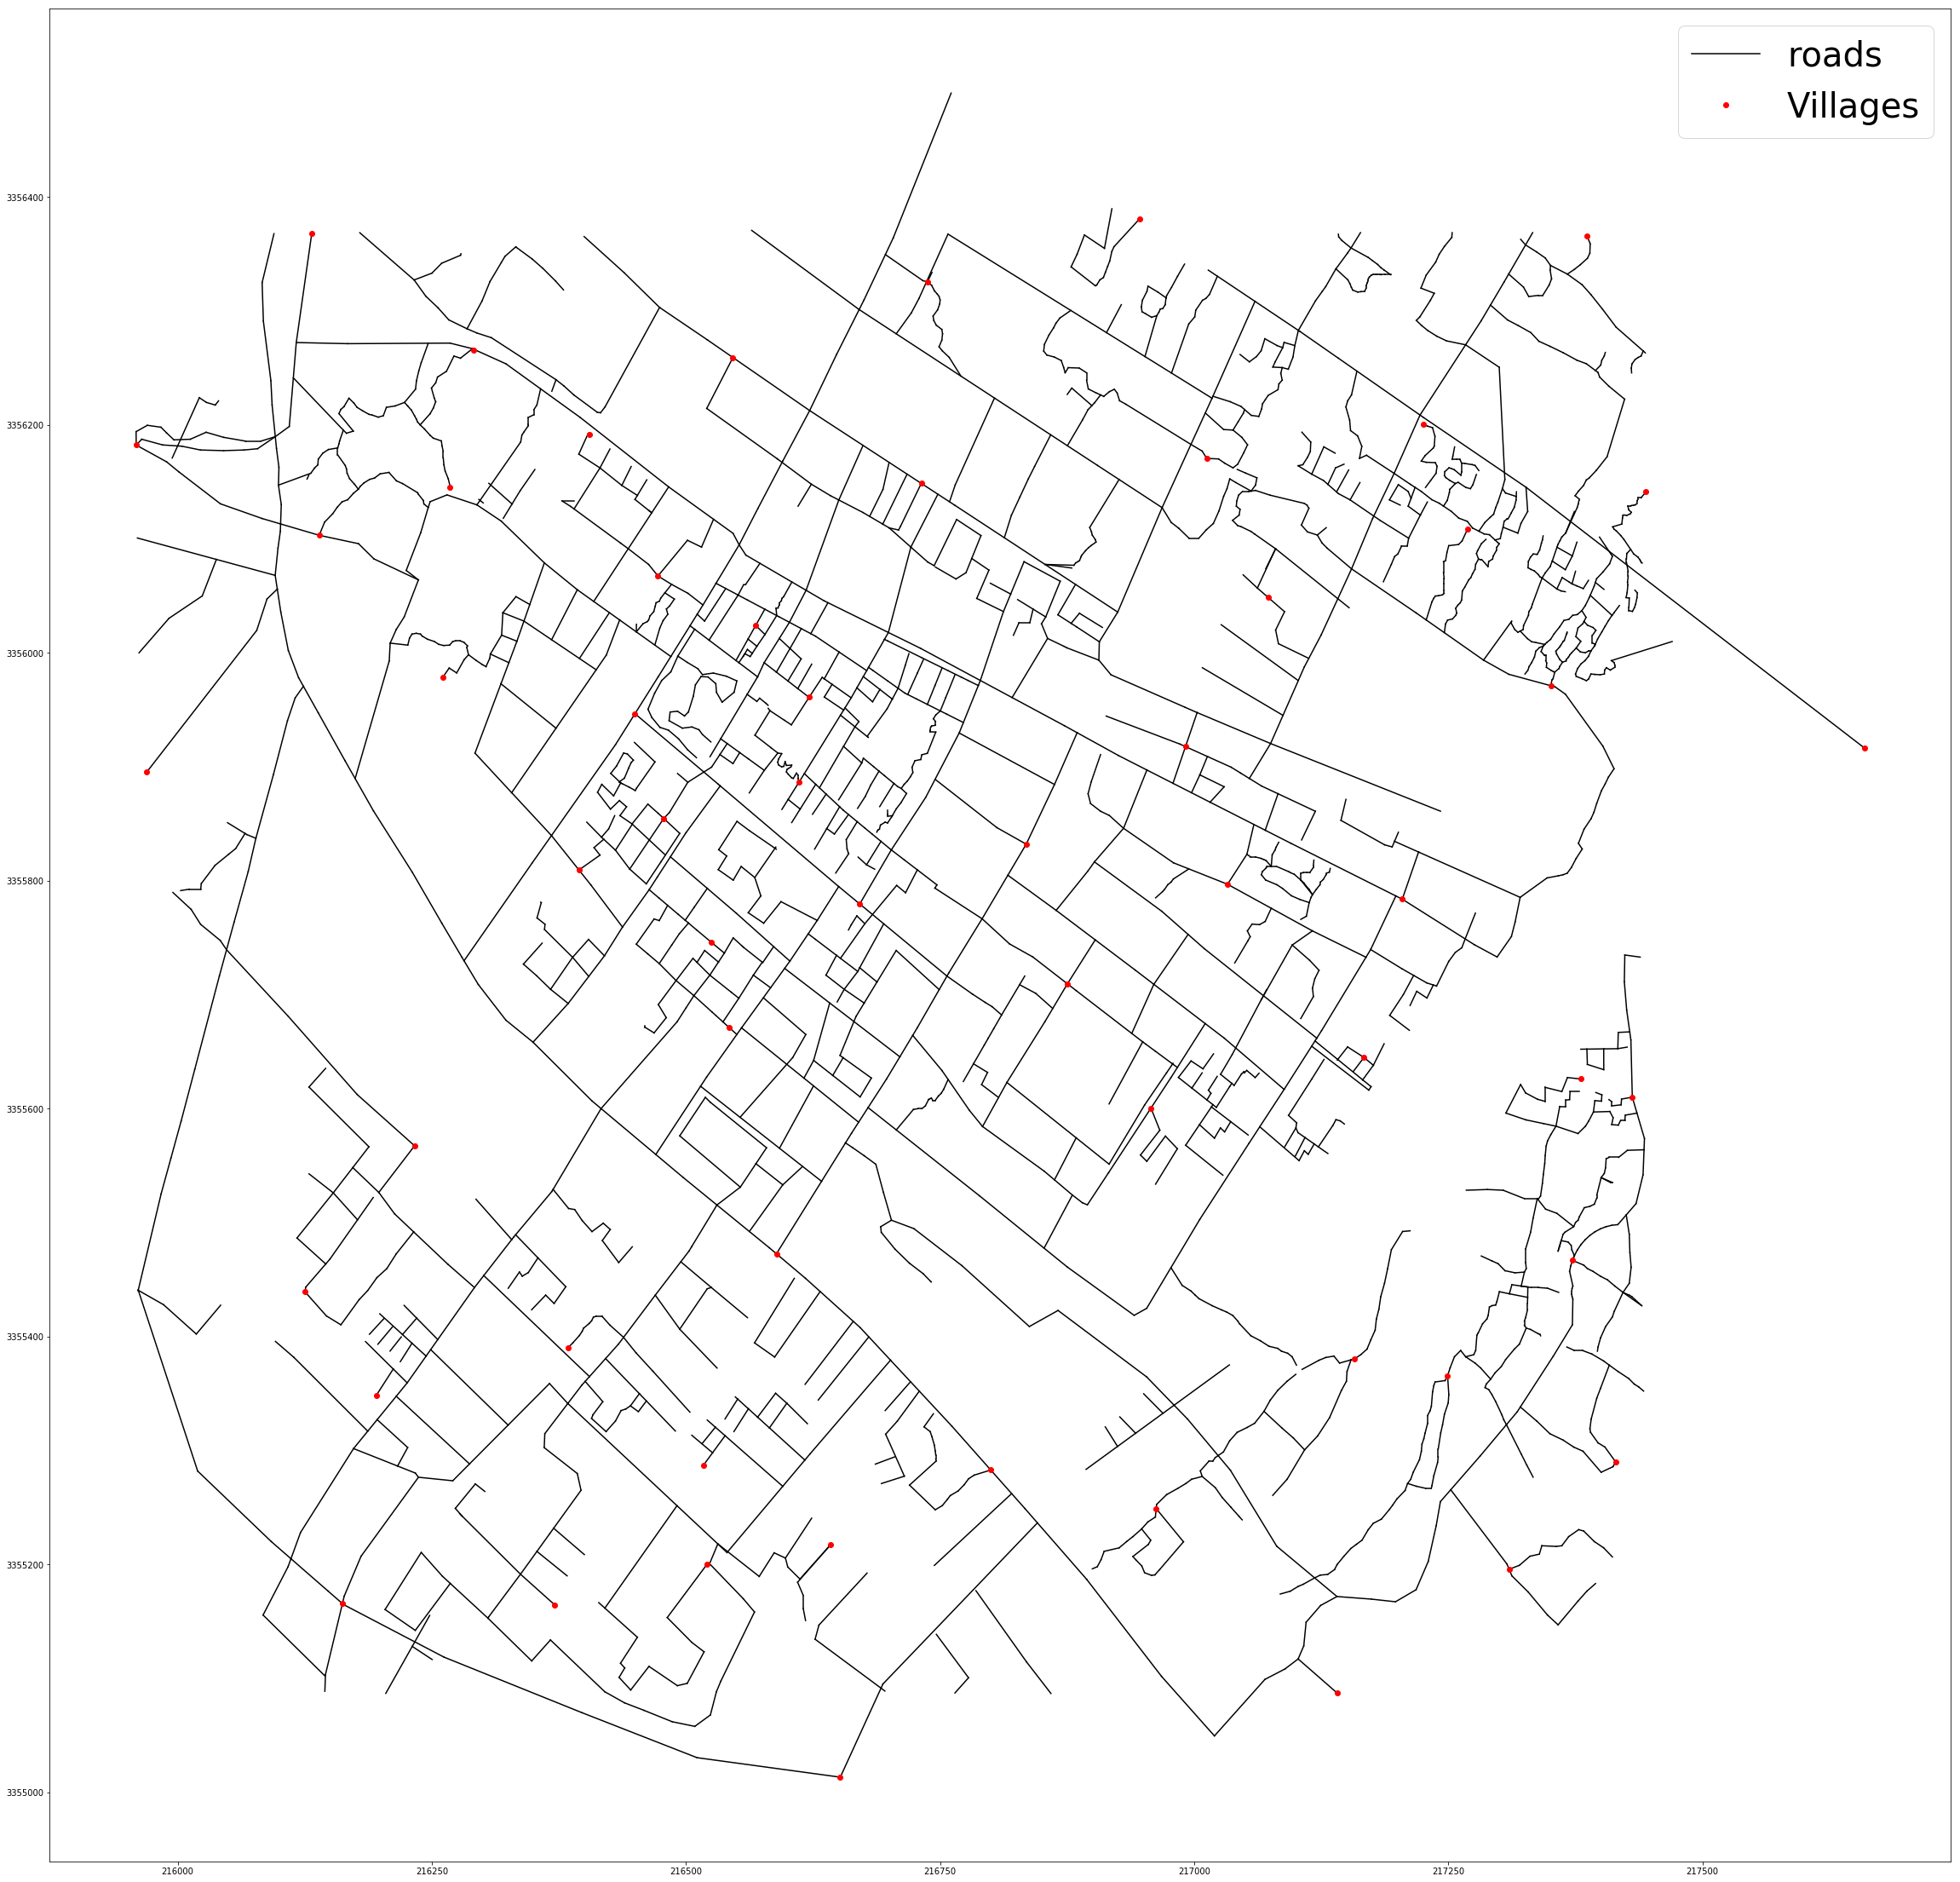

In [33]:
plt.figure(figsize=(40,40))
for edge in g.selected:
    x = [g.nodes[g.findNode(edge.node1)].x, g.nodes[g.findNode(edge.node2)].x]
    y = [g.nodes[g.findNode(edge.node1)].y, g.nodes[g.findNode(edge.node2)].y]
    hnd1, = plt.plot(x,y,color="k",label="roads")
hnd2 = displaypoints(villCoords,1)
plt.legend(handles=[hnd1,hnd2],fontsize=40)
plt.show()